In [16]:
import stompy.model.delft.dflow_model as dfm
import matplotlib.pyplot as plt
import numpy as np
from stompy import utils
import xarray as xr
%matplotlib widget

In [2]:
# Closer look at DFM output -- how well are the harmonics doing?
# map output is 24h, not that useful.
dfm_rundir="/boisevol1/hpcshared/open_bay/hydro/full_res/wy2022_r52184/runs/wy2022_r52184"
model = dfm.DFlowModel.load(dfm_rundir)
hist_ds=model.his_dataset()

Yuck - duplicate source_sink names
Yuck - duplicate stations names


In [7]:
pnt=[ 564438., 4161870.] # also SMB


hist_xy = np.c_[ hist_ds.station_x_coordinate.isel(time=0).values,
                 hist_ds.station_y_coordinate.isel(time=0).values]
station_dist=utils.dist(pnt,hist_xy)
station_idx = np.argmin(station_dist)
# For the SMB point, this is fine -- 700m along channel..
print(f"Point {pnt}: nearest station in history is {station_dist[station_idx]} m away, {hist_xy[station_idx]}")

Point [564438.0, 4161870.0]: nearest station in history is 0.0 m away, [ 564438. 4161870.]


In [10]:
t=hist_ds.time
t

<xarray.DataArray 'time' (time: 9961)>
array(['2021-08-01T00:00:00.000000000', '2021-08-01T01:00:00.000000000',
       '2021-08-01T02:00:00.000000000', ..., '2022-09-19T22:00:00.000000000',
       '2022-09-19T23:00:00.000000000', '2022-09-20T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-08-01 2021-08-01T01:00:00 ... 2022-09-20
Attributes:
    standard_name:  time

/tmp/ipykernel_470264/607417.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  coll=ax.pcolormesh( t,z, temp, cmap='turbo')


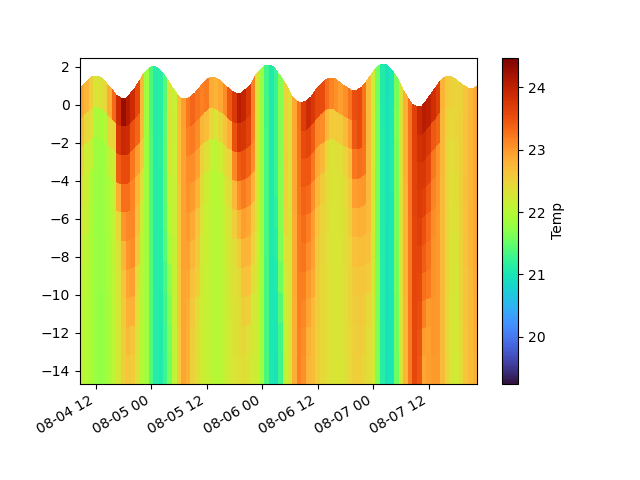

In [22]:
# Time-z temperature around SMB
t_sel = (hist_ds.time.values>np.datetime64("2022-08-01")) & (hist_ds.time.values<np.datetime64("2022-09-01"))

stn_ds=hist_ds.isel(stations=station_idx,time=t_sel)

fig,ax=plt.subplots()

temp = stn_ds['temperature']

t,z = xr.broadcast(temp.time, temp.zcoordinate_c)
coll=ax.pcolormesh( t,z, temp, cmap='turbo')
plt.colorbar(coll,label='Temp')
ax.set_xlim(19208.359, 19211.934)
fig.autofmt_xdate()

In [ ]:
from stompy.io.local import usgs_nwis

smb=11162765
t_start=np.datetime64("2022-08-01")
t_stop =np.datetime64("2022-09-01")

# Probably ts=14740 is lower.
smb_ds = usgs_nwis.nwis_dataset(smb, t_start, t_stop, [10],
                                   name_with_ts_code=True,
                                   cache_dir="cache")

In [50]:
# which layers are closest to USGS sensors? Probably have a half-layer bias in here. meh.
H=stn_ds.waterdepth.mean().values
usgs_layers = (stn_ds.dims['laydim'] * np.r_[10,44] * 0.3048 / H).astype(int)
usgs_layers

array([1, 8])

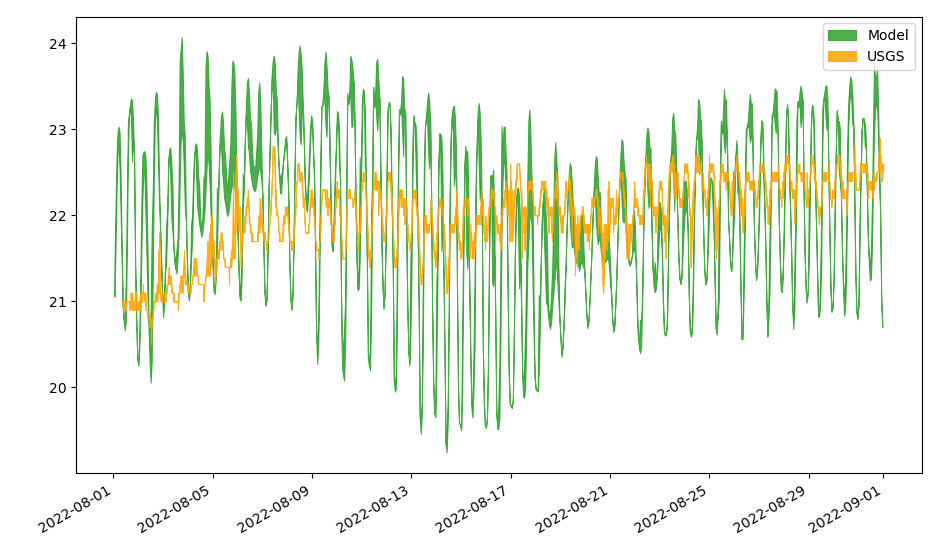

In [51]:
fig,ax = plt.subplots(figsize=(9.5,5.5))

ax.fill_between(temp.time, temp.isel(laydim=usgs_layers[0]), temp.isel(laydim=usgs_layers[1]), 
                label='Model', lw=0.75, fc='tab:green', ec='face', alpha=0.85)
#ax.plot( temp.time, temp.isel(laydim=0), label='Model bed')
#ax.plot( temp.time, temp.isel(laydim=-1), label='Model surface')

ax.fill_between(smb_ds.time, smb_ds.temperature_water_14740,  smb_ds.temperature_water_14738,
                label='USGS', lw=0.75, fc='orange', ec='face', alpha=0.85)
#ax.plot( smb_ds.time, smb_ds.temperature_water_14740, label='USGS Lower',lw=1.0) # 10ft from bed
#ax.plot( smb_ds.time, smb_ds.temperature_water_14738, label='USGS Upper',lw=1.0) # 44ft from bed
ax.legend()
fig.autofmt_xdate()
fig.subplots_adjust(left=0.08,right=0.97,top=0.97,bottom=0.14)